In [1]:
import os
import numpy as np
from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal
from glob import glob
import re
import pandas as pd
import gc
import IPython.display as ipd
from scipy.io import wavfile

from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
import keras

Using TensorFlow backend.


In [2]:
L = 16000
train_audio_path = '../input/sr-data/Data/'
legal_labels = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go',
       'happy', 'house', 'left', 'marvel', 'nine', 'no', 'off', 'on',
       'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree',
       'two', 'up', 'wow', 'yes', 'zero']

Time-domain analysis completely ignores the frequency component whereas frequency domain analysis pays no attention to the time component.

**Spectrogram** is a **2D plot between time and frequency** where each point in the plot represents the amplitude of a particular frequency at a particular time in terms of intensity of color. In simple terms, the spectrogram is a spectrum (broad range of colors) of frequencies as it varies with time. 

In [9]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

**list_wavs_fname** is to retrive the labels, filenames.

In [4]:
def list_wavs_fname(dirpath, ext='wav'):
    print(dirpath)
    fpaths = glob(os.path.join(dirpath, r'*/*' + ext))
    pat = r'.+/(\w+)/\w+\.' + ext + '$'
    labels = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            labels.append(r.group(1))
    pat = r'.+/(\w+\.' + ext + ')$'
    fnames = []
    for fpath in fpaths:
        r = re.match(pat, fpath)
        if r:
            fnames.append(r.group(1))
    return labels, fnames

**pad_audio** will pad audios that are less than 16000(1 second) with 0s to make them all have the same length.

**chop_audio** will chop audios that are larger than 16000(eg. wav files in background noises folder) to 16000 in length. In addition, it will create several chunks out of one large wav files given the parameter 'num'.

**label_transform** transform labels into dummies values. It's used in combination with softmax to predict the label.

In [5]:
def pad_audio(samples):
    if len(samples) >= L: return samples
    else: return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))

def chop_audio(samples, L=16000, num=20):
    for i in range(num):
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]

def label_transform(labels):
    nlabels = []
    for label in labels:
        if label == '_background_noise_':
            nlabels.append('silence')
        elif label not in legal_labels:
            nlabels.append('unknown')
        else:
            nlabels.append(label)
    return pd.get_dummies(pd.Series(nlabels))


In [13]:
labels, fnames = list_wavs_fname(train_audio_path)

../input/sr-data/Data/


In [14]:
len(fnames)

29994

In [15]:
new_sample_rate = 8000
y_train1 = []
x_train1 = []

for label, fname in zip(labels, fnames):
    sample_rate, samples = wavfile.read(os.path.join(train_audio_path, label, fname))
    samples = pad_audio(samples)
    if len(samples) > 16000:
        n_samples = chop_audio(samples)
    else: n_samples = [samples]
    for samples in n_samples:
        resampled = signal.resample(samples, int(new_sample_rate / sample_rate * samples.shape[0]))
        _, _, specgram = log_specgram(resampled, sample_rate=new_sample_rate)
        y_train1.append(label)
        x_train1.append(specgram)
x_train1 = np.array(x_train1)
x_train1 = x_train1.reshape(tuple(list(x_train1.shape) + [1]))
y_train1 = label_transform(y_train1)
label_index = y_train1.columns.values
y_train1 = y_train1.values
y_train1 = np.array(y_train1)
del labels, fnames
gc.collect()

8

In [16]:
x_train1.shape

(29994, 99, 81, 1)

In [17]:
x_train, X_valtest, y_train, y_valtest = train_test_split(x_train1,y_train1, train_size=0.6, random_state=37)
x_val, x_test, y_val, y_test = train_test_split(X_valtest,y_valtest, train_size = 0.5, random_state=37)

In [18]:
import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D,Flatten,Dropout,BatchNormalization

In [19]:
droprate = 0.5

input_shape = (x_train.shape[1],x_train.shape[2],1)
model = Sequential()

model.add(Conv2D(512,kernel_size=(3,3),activation='relu',input_shape=input_shape,padding="same"))
model.add(BatchNormalization())
#model.add(Dropout(droprate))
model.add(MaxPooling2D())

model.add(Conv2D(256,kernel_size=(3,3),activation='relu',border_mode="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
#model.add(Dropout(droprate))

model.add(Conv2D(128,kernel_size=(3,3),activation='relu',border_mode="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D())
#model.add(Dropout(droprate))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(droprate))
model.add(Dense(30, activation='softmax'))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same")`
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same")`
  app.launch_new_instance()


In [20]:
(None,1,x_train.shape[1],x_train.shape[2])
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.build()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 99, 81, 512)       5120      
_________________________________________________________________
batch_normalization_1 (Batch (None, 99, 81, 512)       2048      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 40, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 40, 256)       1179904   
_________________________________________________________________
batch_normalization_2 (Batch (None, 49, 40, 256)       1024      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 20, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 20, 128)      

In [21]:
from keras.callbacks import EarlyStopping
epochs = 10
batch_size = 32
callbacks = [
    EarlyStopping(
        monitor='val_acc', 
        patience=4,
        mode='max',
        verbose=1)
]

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_val, y_val),shuffle=True,callbacks=callbacks)


Train on 17996 samples, validate on 5999 samples
Epoch 1/10
17996/17996 [==============================] - 54s 3ms/step - loss: 2.4247 - accuracy: 0.3770 - val_loss: 1.1771 - val_accuracy: 0.6639
Epoch 2/10
   64/17996 [..............................] - ETA: 44s - loss: 0.8302 - accuracy: 0.7812

/opt/conda/lib/python3.6/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_acc` which is not available. Available metrics are: val_loss,val_accuracy,loss,accuracy
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


17996/17996 [==============================] - 50s 3ms/step - loss: 0.8579 - accuracy: 0.7506 - val_loss: 0.7236 - val_accuracy: 0.7840
Epoch 3/10
17996/17996 [==============================] - 50s 3ms/step - loss: 0.5035 - accuracy: 0.8551 - val_loss: 1.2108 - val_accuracy: 0.6339
Epoch 4/10
17996/17996 [==============================] - 50s 3ms/step - loss: 0.3324 - accuracy: 0.9068 - val_loss: 0.4023 - val_accuracy: 0.8808
Epoch 5/10
17996/17996 [==============================] - 50s 3ms/step - loss: 0.2345 - accuracy: 0.9343 - val_loss: 0.3841 - val_accuracy: 0.8853
Epoch 6/10
17996/17996 [==============================] - 50s 3ms/step - loss: 0.1610 - accuracy: 0.9553 - val_loss: 0.3441 - val_accuracy: 0.9028
Epoch 7/10
17996/17996 [==============================] - 50s 3ms/step - loss: 0.1076 - accuracy: 0.9709 - val_loss: 0.4246 - val_accuracy: 0.8818
Epoch 8/10
17996/17996 [==============================] - 50s 3ms/step - loss: 0.0731 - accuracy: 0.9814 - val_loss: 0.3637 - val

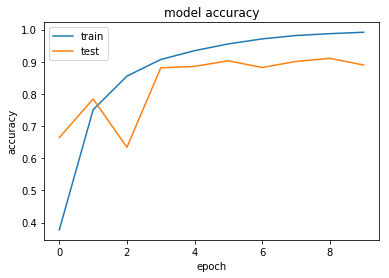

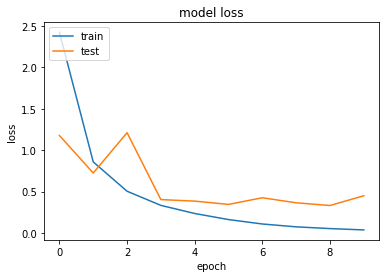

In [22]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
from sklearn.metrics import classification_report
model.evaluate(x_test, y_test, verbose=1)
y_pred = model.predict(x_test, batch_size=32, verbose=1)

y_pred = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)
#print(classification_report(y_test, )

report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
report_df["label"] = legal_labels + ["micro avg","macro avg","weighted avg","samples avg"]
report_df.sort_values(by=['f1-score','support'], ascending=False)

5999/5999 [==============================] - 6s 918us/step


,precision,recall,f1-score,support,label
25,0.968750,0.934673,0.951407,199.0,two
27,0.967742,0.927835,0.947368,194.0,wow
28,0.949721,0.934066,0.941828,182.0,yes
9,0.952128,0.922680,0.937173,194.0,happy
10,0.925581,0.947619,0.936471,210.0,house
18,0.948864,0.922652,0.935574,181.0,right
19,0.898990,0.972678,0.934383,183.0,seven
1,0.983696,0.870192,0.923469,208.0,bird
2,0.930348,0.916667,0.923457,204.0,cat
29,0.965347,0.874439,0.917647,223.0,zero
